In [1]:
# import the required libraries

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# function that would read an image provided the image path, preprocess and return it back

def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # reading the image
    img = cv2.resize(img, (256, 256)) # resizing it (I just like it to be powers of 2)
    img = np.array(img, dtype='float32') # convert its datatype so that it could be normalized
    img = img/255 # normalization (now every pixel is in the range of 0 and 1)
    return img

In [3]:
X_train = [] # To store train images
y_train = [] # To store train labels

# labels -
# 0 - Covid
# 1 - Viral Pneumonia
# 2 - Normal

train_path = "D:/ekeeda/Ekeeda-project/Capestone/Covid19-dataset/train/" # path containing training image samples

In [4]:
for folder in os.scandir(train_path):
    for entry in os.scandir(train_path + folder.name):

        X_train.append(read_and_preprocess(train_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_train.append(0)
        elif folder.name[0]=='V':
            y_train.append(1)
        else:
            y_train.append(2)

In [5]:
X_train = np.array(X_train)
X_train.shape # We have 251 training samples in total

(251, 256, 256, 3)

In [6]:
y_train = np.array(y_train)
y_train.shape

(251,)

## Visualizing the Dataset

<BarContainer object of 3 artists>

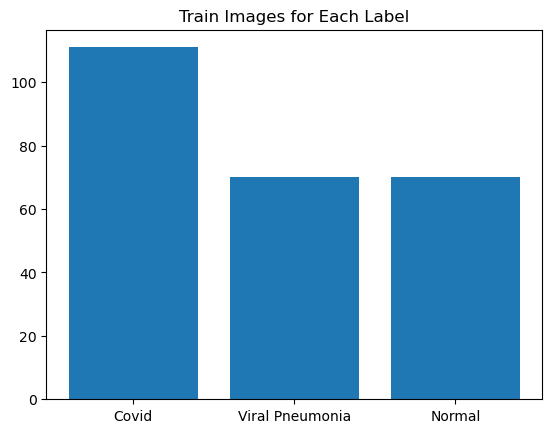

In [7]:
covid_count = len(y_train[y_train==0])
pneumonia_count = len(y_train[y_train==1])
normal_count = len(y_train[y_train==2])

plt.title("Train Images for Each Label")
plt.bar(["Covid", "Viral Pneumonia", "Normal"],[covid_count, pneumonia_count, normal_count])

# We have more number of covid samples that Pneumonia and Normal

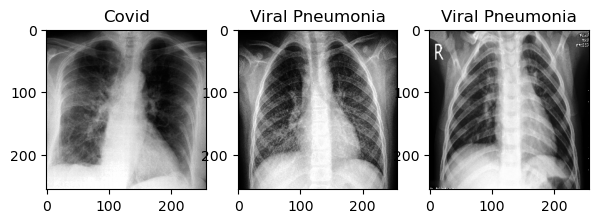

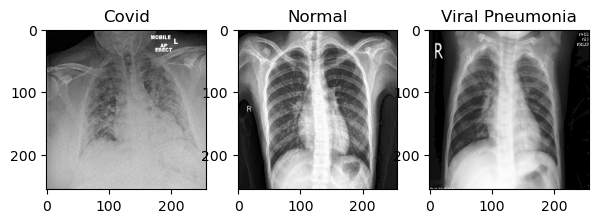

In [8]:
# Plotting 2 images per disease

import random

title = {0:"Covid", 1:"Viral Pneumonia", 2:"Normal"}

rows = 2
columns = 3

for i in range(2):
    
    fig = plt.figure(figsize=(7,7))
    
    fig.add_subplot(rows, columns, 1)
    pos = random.randint(0, covid_count)
    plt.imshow(X_train[pos])
    plt.title(title[y_train[pos]])
    
    fig.add_subplot(rows, columns, 2)
    pos = random.randint(covid_count, covid_count+pneumonia_count)
    plt.imshow(X_train[pos])
    plt.title(title[y_train[pos]])
    
    fig.add_subplot(rows, columns, 3)
    pos = random.randint(covid_count+pneumonia_count, covid_count+pneumonia_count+normal_count)
    plt.imshow(X_train[pos])
    plt.title(title[y_train[pos]])

## Image Augmentation

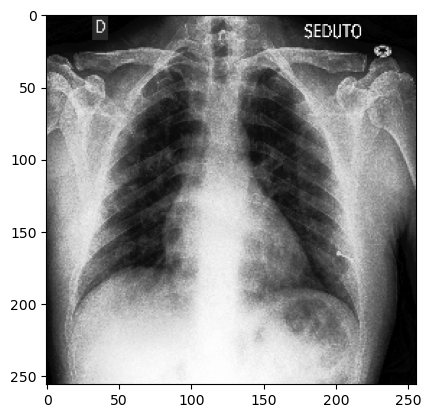

In [9]:
plt.imshow(X_train[0])

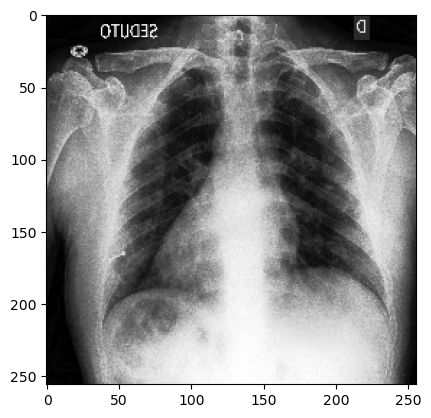

In [10]:
X_new = np.fliplr(X_train[0])
plt.imshow(X_new)

In [11]:
X_aug = []
y_aug = []

for i in range(0, len(y_train)):
    X_new = np.fliplr(X_train[i])
    X_aug.append(X_new)
    y_aug.append(y_train[i])

In [12]:
X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

In [13]:
X_train = np.append(X_train, X_aug, axis=0) # appending augmented images to original training samples
X_train.shape

(502, 256, 256, 3)

In [14]:
y_train = np.append(y_train, y_aug, axis=0)
y_train.shape

(502,)

## Loading the Validation and Test Images

In [15]:
X_val = [] # To store validation and test images
y_val = [] # To store validation and test labels

val_path = 'D:/ekeeda/Ekeeda-project/Capestone/Covid19-dataset/test/'

for folder in os.scandir(val_path):
    for entry in os.scandir(val_path + folder.name):

        X_val.append(read_and_preprocess(val_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_val.append(0)
        elif folder.name[0]=='V':
            y_val.append(1)
        else:
            y_val.append(2)
            
X_val = np.array(X_val)
y_val = np.array(y_val)

In [16]:
X_val.shape # We have 66 images for validation and testing


(66, 256, 256, 3)

<BarContainer object of 3 artists>

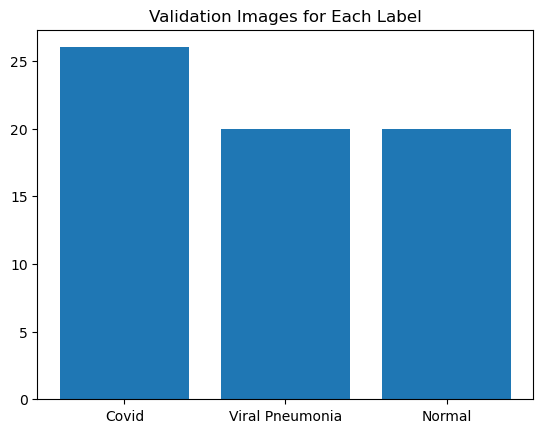

In [17]:
covid_count = len(y_val[y_val==0])
pneumonia_count = len(y_val[y_val==1])
normal_count = len(y_val[y_val==2])

plt.title("Validation Images for Each Label")
plt.bar(["Covid", "Viral Pneumonia", "Normal"],[covid_count, pneumonia_count, normal_count])

# We have more number of covid samples that Pneumonia and Normal in test dataset as well

In [18]:
# Get the ResNet50 base model
basemodel = VGG16(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [19]:
basemodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [20]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [21]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(3, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [23]:
opt = optimizers.Adam(learning_rate=0.0001)

In [24]:
# compile the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics= ["accuracy"])

In [25]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="covid_classifier_weights.h5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), batch_size=16,
                    shuffle=True, callbacks=[earlystopping, checkpointer])

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 0.5659 - accuracy: 0.7669 
Epoch 1: val_loss improved from inf to 0.36435, saving model to covid_classifier_weights.h5
32/32 [==============================] - 438s 14s/step - loss: 0.5659 - accuracy: 0.7669 - val_loss: 0.3643 - val_accuracy: 0.8333
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 0.1440 - accuracy: 0.9462 
Epoch 2: val_loss improved from 0.36435 to 0.11256, saving model to covid_classifier_weights.h5
32/32 [==============================] - 459s 14s/step - loss: 0.1440 - accuracy: 0.9462 - val_loss: 0.1126 - val_accuracy: 1.0000
Epoch 3/100


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("covid_classifier_model.json","w") as json_file:
  json_file.write(model_json)

## Evaluating the Saved Model Performance

In [ ]:
# Load pretrained model (best saved one)
with open('covid_classifier_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('covid_classifier_weights.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics= ["accuracy"])

In [ ]:
predictions = model.predict(X_val)


In [ ]:
predictions.shape

In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, predict)
accuracy

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, cmap='Blues')

# The model misclassified one Normal case as Pneumonia

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_val, predict)
print(report)